**Coonect to GDrive and move to DeepFakeDetector dir**

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/', force_remount=True)

import os
experiment_dir = '/content/drive/MyDrive/Colab Notebooks/DeepFakeDetector'
os.chdir(experiment_dir)
print(f'current cwd = {os.getcwd()}')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/
current cwd = /content/drive/MyDrive/Colab Notebooks/DeepFakeDetector


In [5]:
!pip install pandas

**Import Libraries**

In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import plot_model
from keras import initializers
from __future__ import division

import pydot
import graphviz
import numpy as np

import h5py as h5py

import matplotlib.pyplot as plt

**Create the respective directories**

In [ ]:
# local_zip = '/tmp/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'Real')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'Real')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'DeepFake')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'DeepFake')

**Examples**

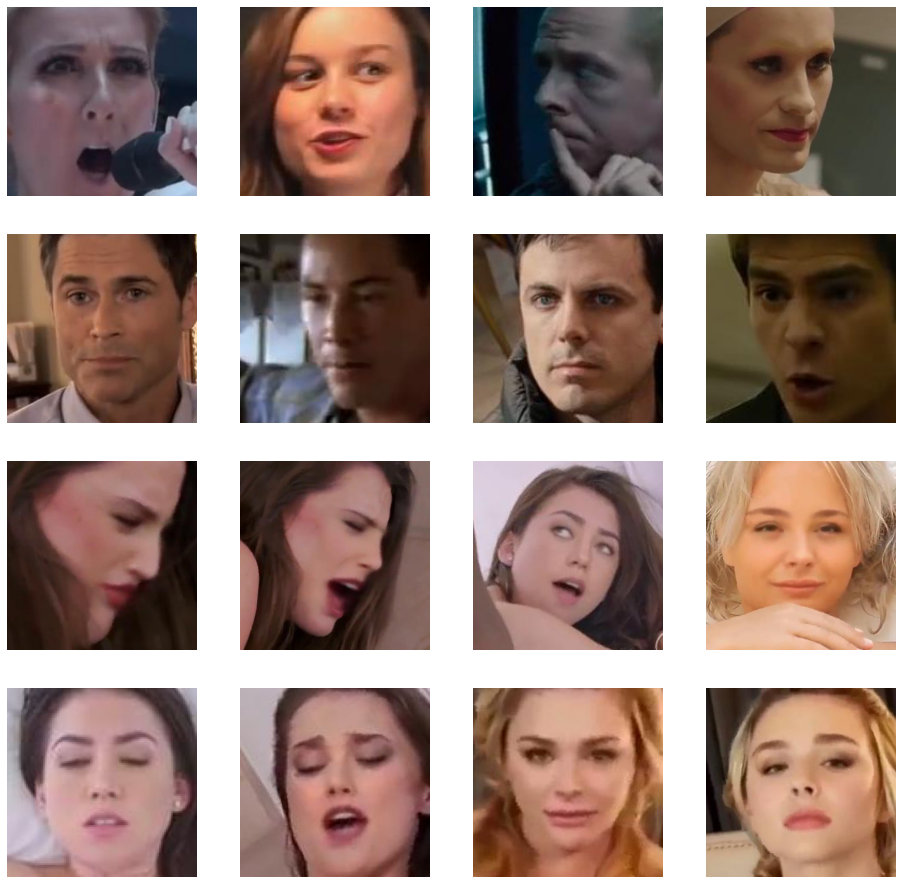

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows, ncols = 4, 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**Import the Inception model**

We are going to use all the layers in the model except for the last fully connected layer as it is specific to the [ImageNet](https://http://image-net.org/challenges/LSVRC/) competition.

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


Make all the layers non trainable (We can retrain some of the lower layers to increase performance. Keep in mind that this may lead to overfitting)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

**Define a Callback class that stops training once accuracy reaches 95%**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

We use binary_crossentropy as the loss metric as we have 2 target classes (it's a binary classification problem)

Our optimizer is **RMSprop** with a learning rate of **0.0001** (We can experiment with this; Adam and Adagrad optimizers would also work well)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

**Flow images in batches of 20 using train _datagen and test_datagen**

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
# Flow training images in batches of 20 using train_datagen generator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))  

# Note that the validation data should not be augmented!
# Flow validation images in batches of 20 using test_datagen generator
test_datagen = ImageDataGenerator(rescale = 1.0/255.)
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size  = 20,
                                                         class_mode  = 'binary', 
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            # steps_per_epoch = 2,
            # validation_steps = 2,
            epochs = 100,
            verbose = 1,
            callbacks=[callbacks])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 990s 10s/step - loss: 2.2635 - acc: 0.7575 - val_loss: 0.2185 - val_acc: 0.9125
Epoch 2/100
100/100 [==============================] - 21s 206ms/step - loss: 0.3555 - acc: 0.8923 - val_loss: 0.4276 - val_acc: 0.8365
Epoch 3/100
100/100 [==============================] - 20s 205ms/step - loss: 0.3336 - acc: 0.8973 - val_loss: 0.2805 - val_acc: 0.9225
Epoch 4/100
100/100 [==============================] - 20s 203ms/step - loss: 0.3151 - acc: 0.9070 - val_loss: 0.7350 - val_acc: 0.8350
Epoch 5/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2459 - acc: 0.9205 - val_loss: 0.2096 - val_acc: 0.9130
Epoch 6/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2169 - acc: 0.9333 - val_loss: 0.2378 - val_acc: 0.9405
Epoch 7/100
100/100 [==============================] - 21s 209ms/step - loss: 0.1587 - acc: 0.9574 - val_loss: 0.3220 - val_acc: 0.9110
Epoch 8/100
100/100 [============================

We were able to achieve a validation accuracy of **95%**
This is the kind of result we were hoping for using **Transfer Learning**; Building upon a pre-trained model and using it in our custom application which was able to achieve great performance after training on just 2000 images.

**Plot Accuracy and Loss**

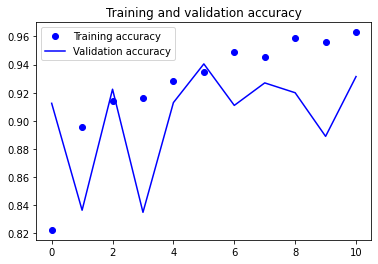

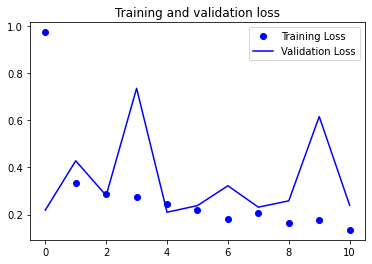

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**An approach where we do not use all the layers in the pre-trained model**

In [ ]:
# last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output

In [ ]:
# last_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output

# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(last_output)
# # Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu')(x)
# # Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# # Add a final sigmoid layer for classification
# x = layers.Dense  (1, activation='sigmoid')(x)           

# model = Model( pre_trained_model.input, x) 

# model.compile(optimizer = RMSprop(lr=0.0001), 
#               loss = 'binary_crossentropy', 
#               metrics = ['acc'])

# # Add our data-augmentation parameters to ImageDataGenerator
# # Flow training images in batches of 20 using train_datagen generator
# train_datagen = ImageDataGenerator(rescale = 1./255.,
#                                    rotation_range = 40,
#                                    width_shift_range = 0.2,
#                                    height_shift_range = 0.2,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size = 20,
#                                                     class_mode = 'binary', 
#                                                     target_size = (150, 150))     


# # Note that the validation data should not be augmented!
# # Flow validation images in batches of 20 using test_datagen generator
# validation_generator =  test_datagen.flow_from_directory(validation_dir,
#                                                          batch_size  = 20,
#                                                          class_mode  = 'binary', 
#                                                          target_size = (150, 150))
# test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# callbacks = myCallback()
# history = model.fit_generator(
#             train_generator,
#             validation_data = validation_generator,
#             steps_per_epoch = 100,
#             epochs = 100,
#             validation_steps = 50,
#             verbose = 2,
#             callbacks=[callbacks])

In [ ]:
# import matplotlib.pyplot as plt
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'bo', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

**Test with custom images**

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = os.path.join(experiment_dir, fn)
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a DeepFake")
  else:
    print(fn + " is a Real")

Saving 176_6 (1) (1).jpg to 176_6 (1) (1) (1).jpg
Saving 176_6 (1).jpg to 176_6 (1) (2).jpg
Saving 176_6 (2).jpg to 176_6 (2) (1).jpg
Saving 176_6.jpg to 176_6 (3).jpg
Saving 176_258 (1) (1).jpg to 176_258 (1) (1) (1).jpg
Saving 176_258 (1).jpg to 176_258 (1) (2).jpg
Saving 176_258 (2).jpg to 176_258 (2) (1).jpg
Saving 176_258.jpg to 176_258 (3).jpg
Saving 176_264 (1) (1).jpg to 176_264 (1) (1) (1).jpg
Saving 176_264 (1).jpg to 176_264 (1) (2).jpg
Saving 176_264 (2) (1).jpg to 176_264 (2) (1) (1).jpg
Saving 176_264 (2).jpg to 176_264 (2) (2).jpg
Saving 176_264 (3).jpg to 176_264 (3) (1).jpg
Saving 176_264.jpg to 176_264 (4).jpg
Saving 179_12 (1) (1).jpg to 179_12 (1) (1) (1).jpg
Saving 179_12 (1).jpg to 179_12 (1) (2).jpg
Saving 179_12 (2).jpg to 179_12 (2) (1).jpg
Saving 179_12.jpg to 179_12 (3).jpg
Saving 179_54 (1) (1).jpg to 179_54 (1) (1) (1).jpg
Saving 179_54 (1).jpg to 179_54 (1) (2).jpg
Saving 179_54 (2).jpg to 179_54 (2) (1).jpg
Saving 179_54.jpg to 179_54 (3).jpg
Saving 179_1